In [3]:
import joblib
import pandas as pd
import seaborn as sb
import glob
import matplotlib.pyplot as plt
import truvari
from sklearn.metrics import roc_curve, roc_auc_score

In [4]:
data = pd.read_csv("bench_summary.txt", sep='\t')

In [5]:
data["ref (prog)"] = data['reference'] + ' (' + data['caller'].apply(lambda x: x[0].upper()) + ')'
data["Merge"] = data["pVCF merge"]

/var/folders/fy/lkd5_yz90zq3f67qys3tpztc0000gn/T/ipykernel_6653/3642446992.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  p.set_yticklabels(["%d" % (x // 1000) for x in p.get_yticks()])


[Text(0.5, 1.0, 'Short-Read Recall of Merge pVCF SVs'),
 Text(0.5, 0, 'Reference (SV Caller)'),
 Text(0, 0.5, 'TP calls (thousands)')]

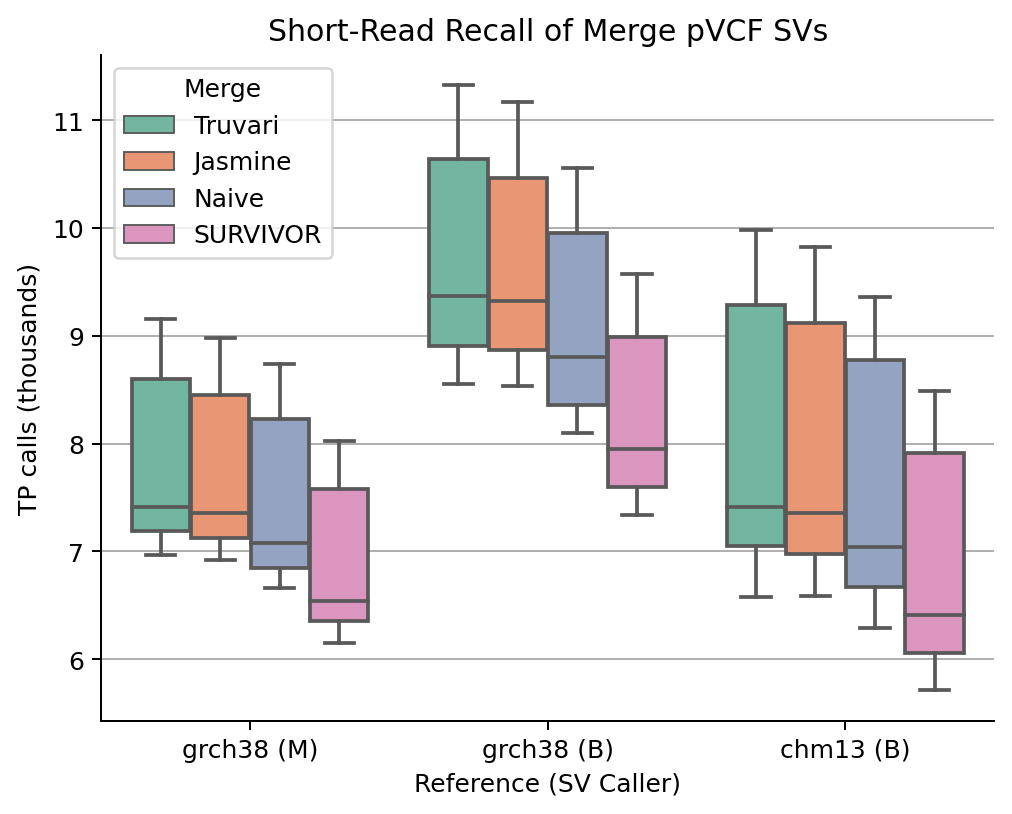

In [6]:
plt.figure(dpi=180)
p = sb.boxplot(data=data, 
               x='ref (prog)', 
               y="TP-call", 
               hue='Merge',
               order=['grch38 (M)', 'grch38 (B)', 'chm13 (B)'],
               hue_order=["Truvari", "Jasmine", "Naive", "SURVIVOR"],
              palette='Set2')
sb.despine()
plt.grid(which='major', axis='y')
p.set_axisbelow(True)
#print(p.get_yticks())
p.set_yticklabels(["%d" % (x // 1000) for x in p.get_yticks()])
p.set(title="Short-Read Recall of Merge pVCF SVs", xlabel="Reference (SV Caller)", ylabel="TP calls (thousands)")

In [7]:
data.groupby(['ref (prog)', 'Merge'])["TP-call"].mean().unstack().round().astype(int)[["Truvari", "Jasmine", "Naive", "SURVIVOR"]].mean()


Merge
Truvari     8704.00
Jasmine     8623.75
Naive       8211.00
SURVIVOR    7482.50
dtype: float64

In [8]:
print(data.groupby(['ref (prog)'])["f1"].mean())
print(data.groupby(['ref (prog)'])["f1"].std())



ref (prog)
chm13 (B)     0.444775
grch38 (B)    0.480653
grch38 (M)    0.436636
hg19 (B)      0.478057
Name: f1, dtype: float64
ref (prog)
chm13 (B)     0.011323
grch38 (B)    0.012256
grch38 (M)    0.014069
hg19 (B)      0.011942
Name: f1, dtype: float64


In [9]:
print(data.groupby(['ref (prog)'])["recall"].mean())
print(data.groupby(['ref (prog)'])["recall"].std())


ref (prog)
chm13 (B)     0.329683
grch38 (B)    0.372062
grch38 (M)    0.302503
hg19 (B)      0.370178
Name: recall, dtype: float64
ref (prog)
chm13 (B)     0.016239
grch38 (B)    0.019674
grch38 (M)    0.017546
hg19 (B)      0.019492
Name: recall, dtype: float64


In [10]:
data.groupby(['ref (prog)', 'Merge'])["precision"].mean().unstack().round(2)[["Truvari", "Jasmine", "Naive", "SURVIVOR"]]


Merge,Truvari,Jasmine,Naive,SURVIVOR
ref (prog),,,,
chm13 (B),0.72,0.71,0.68,0.62
grch38 (B),0.71,0.71,0.67,0.61
grch38 (M),0.82,0.81,0.78,0.72
hg19 (B),0.71,0.70,0.67,0.61


In [11]:
from collections import defaultdict
lr_data = pd.read_csv("../inter_sample_merge/SV_count_af_summary.tsv", sep='\t')
lr_data = lr_data[["reference", "merge", "tot_cnt"]].copy()
lr_data.columns = ["Reference", "Merge", "Count"]
lr_data["Callset"] = "Assemblies"

sr_data = pd.read_csv("pvcf_count.txt", sep='\t')
names = defaultdict(lambda: 'BioGraph')
names['manta'] = "Manta"
sr_data["Callset"] = sr_data["Reference"].map(names)
#pd.concat([data, pd.Series(['a', 'b', 1])], axis=0)

In [12]:
sr_data['Reference'] = sr_data["Reference"].where(sr_data["Reference"] != 'manta', "grch38")

/var/folders/fy/lkd5_yz90zq3f67qys3tpztc0000gn/T/ipykernel_6653/3746165090.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  p.set_yticklabels(["%d" % (x // 1000) for x in p.get_yticks()])
/var/folders/fy/lkd5_yz90zq3f67qys3tpztc0000gn/T/ipykernel_6653/3746165090.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  hide = p.set_xticklabels(["BCFtools", "Truvari", "Jasmine", "Naive", "SURVIVOR"])


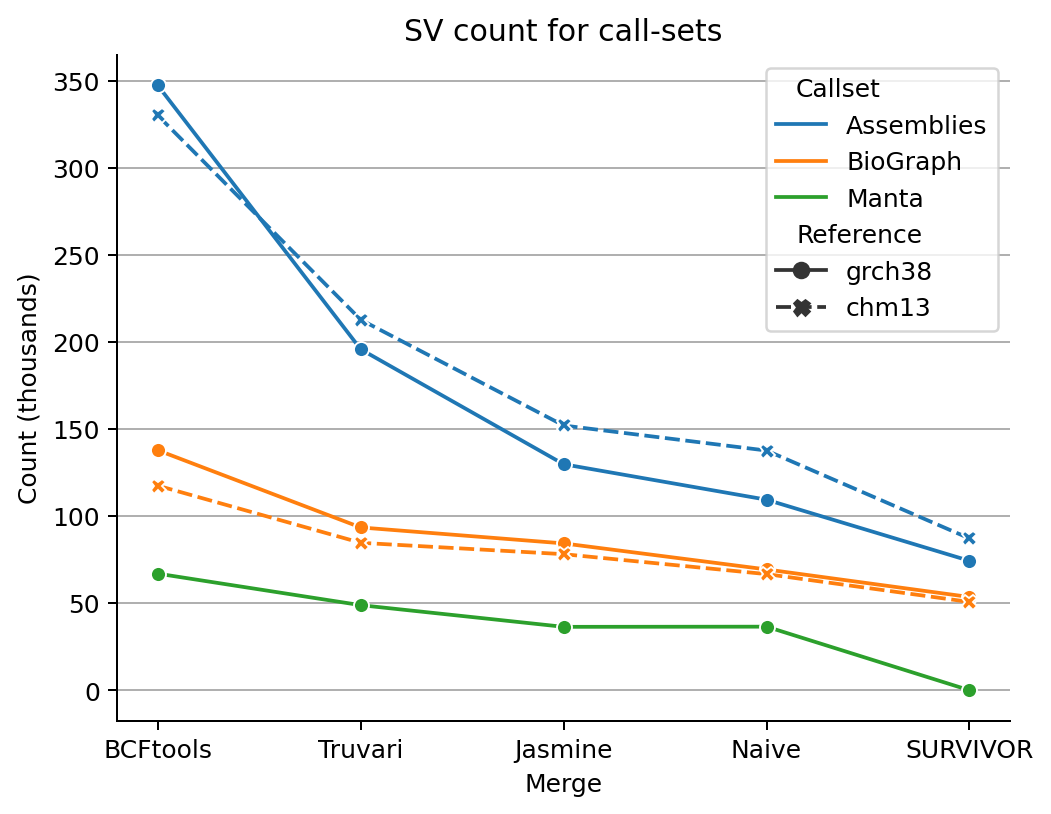

In [13]:
plt.figure(dpi=180)
counts = pd.concat([sr_data, lr_data], axis=0).reset_index()
counts["Merge"] = counts['Merge'].map({'exact':"BCFtools",
                                         'jasmine':"Jasmine",
                                         'survivor':"SURVIVOR",
                                         'truvari':"Truvari",
                                         'naive':"Naive"})
parts = []
for i in ["BCFtools", "Truvari", "Jasmine", "Naive", "SURVIVOR"]:
    parts.append(counts[counts["Merge"] == i])
counts = pd.concat(parts)
p = sb.lineplot(data=counts[counts["Reference"] != 'hg19'], 
                x="Merge", sort=False,#order=["exact", "truvari", "jasmine", "naive", "survivor"],
                y="Count", 
                hue="Callset", hue_order=["Assemblies", "BioGraph", "Manta"],
                style_order=["grch38", "chm13"],
                style='Reference', markers=True)
sb.despine()
plt.grid(which='major', axis='y')
p.set_axisbelow(True)
p.set_yticklabels(["%d" % (x // 1000) for x in p.get_yticks()])
p.set(title="SV count for call-sets", ylabel="Count (thousands)", xlabel="Merge")
hide = p.set_xticklabels(["BCFtools", "Truvari", "Jasmine", "Naive", "SURVIVOR"])
